<a href="https://colab.research.google.com/github/alouwyck/vives-deep-learning/blob/main/Chollet_DL_HFST4_no_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

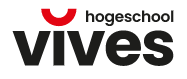<br>


**DEEP LEARNING**<br>
Academiejaar 2022-2023<br>
Andy Louwyck

---



---



# **4. Getting started with neural networks**

Hoofdstuk 4 uit het boek "Deep Learning with Python" (2e editie) van François Chollet

- Classifying movie reviews:
  - Binaire classificatie
  - IMDB dataset
- Classifying newswires:
  - Multi-class classificatie
  - Reuters dataset
- Predicting house prices:
  - Regressie
  - Boston Housing Prices dataset

##  4.1. Classifying movie reviews: A binary classification example

- Binaire classificatie: 2 klassen
- Hier: is de review van een film positief of negatief?

### 4.1.1. The IMDB dataset

- https://www.imdb.com/
- 50.000 reviews:
  - 50% positief, 50% negatief = gebalanceerde dataset!
  - 25.000 training, 25.000 testing


In [ ]:
from tensorflow.keras.datasets import imdb  # beschikbaar in Keras!

In [ ]:
# load_data functie retourneert tuple van 2 tuples met telkens 2 elementen: data en labels
# num_words beperkt de bag of words tot de 10.000 meest voorkomende woorden

num_words = 10_000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)

In [ ]:
# elke sample is een review
# elke sample bestaat uit een list met indices van de woorden uit de review
train_data[0][:10]  # eerste 10 woorden uit de eerste review

In [ ]:
# label = 1: positieve review
# label = 0: negatieve review
train_labels[0]

In [ ]:
# 10.000 woorden in de bag of words -> maximale index is 9999!
print(max([max(review) for review in train_data]))  # list comprehension
print(max([max(review) for review in test_data]))

In [ ]:
# indices omzetten naar woorden
word_index = imdb.get_word_index()  # dict {word=index}
reverse_word_index = {index: value for value, index in word_index.items()} # we willen dict {index=word}
" ".join([reverse_word_index[i] for i in train_data[0]])

### 4.1.2. Preparing the data

Probleem: samples hebben niet dezelfde lengte, want elke review heeft verschillend aantal woorden

Hoe de lists met indices even lang maken?
- **Padding**: nullen toevoegen --> integer tensor (num_samples, max_length) --> Embedding layer
- **Multi-Hot Enconding**: boolean tensor (num_samples, num_words) --> Dense layer

In [ ]:
# Multi-hot encoding
import numpy as np

def vectorize(data):
    x = np.zeros((len(data), num_words))
    for i, review in enumerate(data):
        x[i, review] = 1.
    return x

x_train = vectorize(train_data)
x_test = vectorize(test_data)

In [ ]:
# labels omzetten naar numpy array van type float32
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

### 4.1.3. Building your model

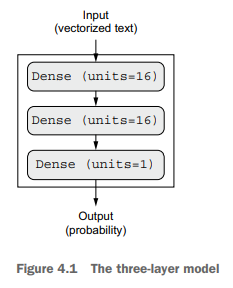

- Tussenlagen: RELU activatiefunctie
- Outputlaag: Sigmoïde activatiefunctie

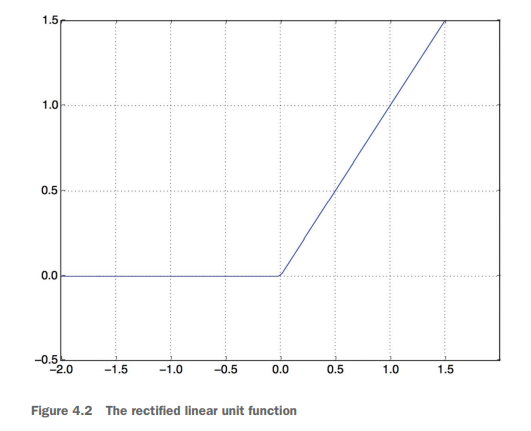

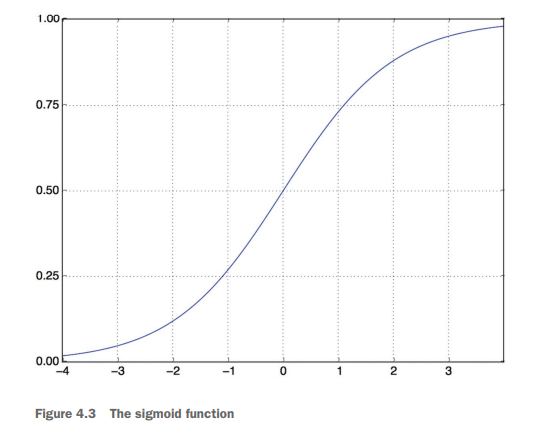

**Activatiefuncties?**
- zie cursus Machine Learning Fundamentals
- boek pag 100-101

**Loss functie?**
- binaire classificatie: `binary_crossentropy`
- nog andere mogelijkheden, bv. `mean_squared_error`
- zie cursus Machine Learning Fundamentals

**Optimizer?**
- `rmsprop`
- variant op Stochastic Gradient descent
- goeie keuze ongeacht het probleem...

**Evaluatiemetriek?**
- nauwkeurigheid (accuracy)
- zie cursus Machine Learning Fundamentals

In [ ]:
# model definiëren

from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

In [ ]:
# model compileren

model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

### 4.1.4. Validating your approach

- training dataset: aanpassen van gewichten/parameters door het algoritme
- validatie dataset: aanpassen hyperparameters door gebruiker + checken of er geen ovefitting is
- test dataset: finale evaluatie door gebruiker op data die niet tijdens het trainen zijn gebruikt

In [ ]:
# 10.000 samples uit trainingset opzij zetten voor validatie

n = 10_000
x_val = x_train[:n]
partial_x_train = x_train[n:]
y_val = y_train[:n]
partial_y_train = y_train[n:]

In [ ]:
# model trainen

result = model.fit(
    partial_x_train,  # samples
    partial_y_train,  # labels
    epochs=20,        # aantal keren dat trainingset wordt doorlopen
    batch_size=512,   # batch = aantal samples dat samen wordt genomen
    validation_data=(x_val, y_val)  # validatieset
)

In [ ]:
result.history.keys()

In [ ]:
# loss-functie plotten

import matplotlib.pyplot as plt

history_dict = result.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

In [ ]:
# nauwkeurighied plotten

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

Conclusie: **OVERFITTING!!**

=> opnieuw trainen:

- Training stoppen na 4 epochs (omdat vanaf dan de validation loss weer stijgt...)
- We hoeven niet meer te valideren, dus we gebruiken de volledige training dataset!
- We doen een finale evaluatie op de testset

In [ ]:
# hertrainen model "from scratch"

# build
model = keras.Sequential([
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

# compile
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# fit
result = model.fit(
    x_train,   # we nemen de volledige trainingset!
    y_train,
    epochs=4,  # 4 ipv 20!!
    batch_size=512,
)

In [ ]:
# test
model.evaluate(x_test, y_test)  # retourneert [loss, acc]

Niet bijster goed! State-of-the-art benadering nodig om 95% nauwkeurigheid te halen!

### 4.1.5. Using a trained model te generate predictions on new data

In [ ]:
# voorspelling maken met nieuwe data
predictions = model.predict(x_test)  # geeft voor elke sample de kans dat review positief is
predictions

In [ ]:
# labels: 0 (=negatief) of 1 (=positief)
y_pred = np.round(predictions)  # afronden
y_pred

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true=y_test, y_pred=y_pred)

In [ ]:
confusion_matrix(y_true=y_test, y_pred=y_pred).sum()

In [ ]:
confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[0, 1], normalize='true')

In [ ]:
# true negatives, false positives, false negatives, true positives
tn, fp, fn, tp = confusion_matrix(y_true=y_test, y_pred=y_pred).ravel()
tn, fp, fn, tp

### 4.1.6. Further experiments

- boek pag 105 (onderaan)
- zelf uitproberen!

## 4.2. Classifying newswires: A multiclass classification example

Multiclass classificatie: meer dan 2 klassen

- klassen zijn disjunct (= mutueel exclusief): elke sample behoort tot juist 1 klasse = **SINGLE-label multiclass classification**
- klassen "overlappen": elke sample kan tot meerdere klassen behoren = **MULTIlabel multiclass classification**

Hier: elk nieuwsitem uit de Reuters dataset onderbrengen in 1 van 46 mogelijke topics (=single-label multiclass classificatie)

### 4.2.1. The Reuters dataset

- Reuters is een internationale nieuwsdienst: https://www.reuters.com/
- nieuwsitems uit 1986
  - 46 topics, elk topic heeft minstens 10 examples in de dataset
  - 8982 examples in de training dataset
  - 2246 examples in de test dataset
  

In [ ]:
from tensorflow.keras.datasets import reuters  # beschikbaar in Keras!

In [ ]:
# load_data functie retourneert tuple van 2 tuples met telkens 2 elementen: data en labels
# num_words beperkt de bag of words tot de 10.000 meest voorkomende woorden

num_words = 10_000
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=num_words)

In [ ]:
# check aantal samples
print(len(train_data))
print(len(test_data))

In [ ]:
# cfr IMDB dataset: elke sample is een list van integers (= woord indices)
train_data[10][:5]  # eerste 5 indices van 11e example (= nieuwsitem)

In [ ]:
# label geeft de klasse (= topic)
train_labels[10]  # geeft de index, zoek via internet de overeenkomstige topic op!

In [ ]:
# cfr IMDB dataset: 10.000 woorden in de bag of words -> maximale index is 9999!
print(max([max(item) for item in train_data]))  # list comprehension
print(max([max(item) for item in test_data]))

In [ ]:
# 46 klassen -> maximale index in labels is 45!
print(max(train_labels))
print(max(test_labels))

In [ ]:
# cfr IMDB dataset: indices omzetten naar woorden
word_index = reuters.get_word_index()  # dict {word=index}
reverse_word_index = {index: value for value, index in word_index.items()} # we willen dict {index=word}
" ".join([reverse_word_index[i] for i in train_data[10]])

### 4.2.2. Preparing the data

Training examples:

In [ ]:
# Cfr IMDB dataset: Multi-hot encoding
import numpy as np

def vectorize(data):
    x = np.zeros((len(data), num_words))
    for i, review in enumerate(data):
        x[i, review] = 1.
    return x

x_train = vectorize(train_data)
x_test = vectorize(test_data)

Labels:
- **casting**: list -> integer tensor
- **one-hot encoding**: zie Machine Learning Fundamentals

In [ ]:
# One-hot encoding

num_classes = 46

def to_one_hot(labels):
    n = len(labels)
    y = np.zeros((n, num_classes))
    y[np.arange(n), labels] = 1.0
    return y

y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

In [ ]:
# of built-in functie van Keras gebruiken...
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

### 4.2.3. Building your model

Cfr IMDB model... Maar:
- Output laag moet nu size 46 hebben ipv 2!
- Daarom hebben ook de tussenlagen nu een grotere size, nl. 46
- Activatiefunctie van outputlaag is nu `softmax` ipv sigmoïde:
  - geeft per example 46 kansen waarvan de som gelijk is aan 1
  - zie Machine Learning Fundamentals
- Loss functie is nu `categorical_crossentropy` ipv `binary_crossentropy`

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers


# build
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")  # softmax ipv sigmoid!
])

# compile
model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",  # categorical ipv binary!
    metrics=["accuracy"]
)

### 4.2.4. Validating your approach

In [ ]:
# 1000 samples uit trainingset opzij zetten voor validatie

n = 1000
x_val = x_train[:n]
partial_x_train = x_train[n:]
y_val = y_train[:n]
partial_y_train = y_train[n:]

In [ ]:
# model trainen

result = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val, y_val)
)

In [ ]:
import matplotlib.pyplot as plt

# loss plotten
loss = result.history["loss"]
val_loss = result.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

In [ ]:
# nauwkeurigheid plotten
acc = result.history["accuracy"]
val_acc = result.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

Conclusie: OVERFITTING vanaf epoch 9

=> model hertrainen + finaal evalueren op test dataset

In [ ]:
# build
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])

# compile
model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# trainen: geen validatie meer nodig!
result = model.fit(
    x_train,  # op volledige training set!
    y_train,
    epochs=9,  # beperken tot 9 epochs ipv 20
    batch_size=512
)

In [ ]:
# evalueren op test dataset
model.evaluate(x_test, y_test)  # retourneert [loss, acc]

Wat betekent die bijna 80% nauwkeurigheid?
- Random binaire classifier geeft 50% nauwkeurigheid
- Welke nauwkeurigheid geeft random multiclass classifier?

In [ ]:
test_labels_copy = test_labels.copy()
np.random.shuffle(test_labels_copy)  # shuffle de labels willekeurig = random classifier
hits = test_labels_copy == test_labels
hits.mean()

Conclusie: random classifier geeft bijna 20%, ons neuraal netwerk geeft bijna 80%, dus niet slecht :-)

### 4.2.5. Generating predictions on new data

In [ ]:
# voorspelling maken met nieuwe data
predictions = model.predict(x_test)  # geeft voor elke sample 46 kansen
predictions.shape

In [ ]:
# kansen voor elke sample moeten in totaal gelijk zijn aan 1 (= 100%)
print(np.all(predictions.sum(axis=1) == 1.0))  # geeft False door afrondingsfouten
print(np.all(predictions.sum(axis=1) > 0.99999))  # geeft True

In [ ]:
# de kansen van het eerste nieuwsitem uit de test dataset
print(len(predictions[0]))  # 46 kansen
predictions[0]

In [ ]:
# gebruik argmax functie om de klasse te vinden met de grootste kans
np.argmax(predictions[0])

### 4.2.6. A different way to handle the labels and the loss

Labels parsen naar integer tensor/array

In [ ]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

print(y_train.dtype)
print(y_test.dtype)

Enkel loss functie aanpassen:
- `categorical_entropy`: categorical (one-hot) encoding
- `sparse_categorical_entropy`: integer labels
- beide loss functies zijn wiskundig hetzelfde, maar hebben andere interface

In [ ]:
# build
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])

# compile
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",  # sparse !!
    metrics=["accuracy"]
)

# trainen
result = model.fit(
    x_train,
    y_train,
    epochs=9,
    batch_size=512
)

In [ ]:
# evalueren op test dataset
model.evaluate(x_test, y_test)  # retourneert [loss, acc]

### 4.2.7. The importance of having sufficiently large intermediate layers

Outputlaag is 46 dimensionaal

=> Tussenlagen mogen niet minder dan 46 knopen hebben!

In [ ]:
# build
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="relu"),  # 4 nodes ipv 64!!
    layers.Dense(46, activation="softmax")
])

# compile
model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# fit
model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=128,
    validation_data=(x_val, y_val)
)

Conclusie: veel lagere nauwkeurigheid door verlies aan informatie!!

### 4.2.6. Further experiments

- boek pag 113 (bovenaan)
- zelf uitproberen!

## 4.3.  Predicting house prices: A regression example

- Classificatie: labels zijn kwalitatief (discreet)
- Regressie: labels zijn kwantitatief (continu)

### 4.3.1. The Boston housing price dataset

- prijzen van huizen in Boston (USA) uit de jaren '70 + gegevens over aantal kamers, criminaliteit, belastingen, ...
- weinig datapunten:
  - 404 training samples
  - 102 test samples
- features hebben verschillende schaal -> herschalen
- we voorspellen huisprijzen = regressie

NOOT: de dataset zit ook in scikit-learn, maar zal er uit verwijderd worden in toekomstige versie omwille van ethische problemen:

- https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html
- https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8

In [ ]:
from tensorflow.keras.datasets import boston_housing  # beschikbaar in Keras!

In [ ]:
# load_data functie retourneert tuple van 2 tuples met telkens 2 elementen: data en labels

(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

In [ ]:
# aantal samples checken
print(train_data.shape)  # 404 samples, 13 features
print(test_data.shape)  # 102 samples, 13 features

In [ ]:
# labels: mediaan van huisprijzen in 1000$
print(train_labels.dtype)
train_labels[:10]

### 4.3.2. Preparing the data

- **Herschalen**:
  - zie cursus Machine Learning Fundamentals
  - formule: `(x - xmin) / (xmax - xmin)`
  - met `xmin` en `xmax` het minimum en maximum van `x` resp.
  - voorbeeld: percentages omzetten naar getallen tussen 0 en 1 met `xmin = 0` en `xmax = 100`
- **Standaardiseren**:
  - data omzetten naar z-scores die standaardnormaal verdeeld zijn.
  - formule: `(x - xmean) / xstd`
  - met `xmean` en `xstd` het gemiddelde en de standaardafwijking van `x` resp.
- Opgelet!
  - standaardiseren en normaliseren worden vaak door elkaar gebruikt
  - normaliseren betekent in het Engels vaak standardize...
  - en in het boek is standaardiseren gelijk aan normalize.
  

In [ ]:
# standaardiseren
mean = train_data.mean(axis=0)  # gemiddelde
std = train_data.std(axis=0)  # standaarddeviatie
train_data -= mean
train_data /= std
test_data -= mean
test_data /= std

**OPGELET!!!**
- gemiddelde en standaarddeviatie van trainingdata worden ook gebruikt om de test data te standaardiseren!
- gebruik nooit test data voor de training!

### 4.3.3. Building your model

scalar regression (= 1 continue waarde voorspellen):
- outputlaag heeft geen activatiefunctie = lineair
- loss-functie: Mean Squared Error (MSE) (zie cursus Machine Learning Fundamentals)
- evaluatiemetriek: Mean Absolute Error (MAE) (zie cursus Machine Learning Fundamentals)

In [ ]:
from tensorflow import keras
from keras import layers

# functie definiëren omdat we het model meerdere keren moeten instantiëren
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)  # lineaire laag
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

### 4.3.4. Validating your approach using K-fold validation

weinig data -> k-fold cross validation

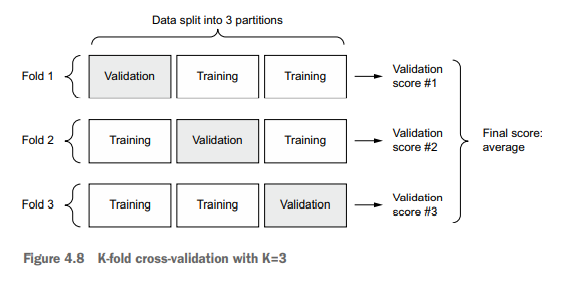

In [ ]:
# k-fold cross-validation
# listings 4.26 en 4.27 samengevoegd

import numpy as np

k = 4  # 4 partities of "folds"
num_val_samples = len(train_data) // k  # integer division!!
num_epochs = 500
all_mae_histories = []
all_scores = []

for i in range(k):

  print(f"Processing fold #{i}")

  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_labels = train_labels[i * num_val_samples: (i + 1) * num_val_samples]

  partial_train_data = np.concatenate(
      [train_data[:i * num_val_samples],
      train_data[(i + 1) * num_val_samples:]],
      axis=0
  )
  partial_train_labels = np.concatenate(
      [train_labels[:i * num_val_samples],
      train_labels[(i + 1) * num_val_samples:]],
      axis=0
  )

  model = build_model()
  result = model.fit(
      partial_train_data,
      partial_train_labels,
      epochs=num_epochs,
      batch_size=16,
      verbose=0,  # silent mode
      validation_data=(val_data, val_labels)  # "automatische" validatie via methode fit()
  )

  mae_history = result.history['val_mae']
  all_mae_histories.append(mae_history)  # list van arrays
  val_mse, val_mae = model.evaluate(val_data, val_labels, verbose=0)  # "manuele" validatie via methode evaluate()
  all_scores.append(val_mae)  # list van scores

In [ ]:
# gemiddelde MAE berekend via fit()
# all_mae_histories is een list van k=4 arrays
# elke array bevat de MAE na elke epoch
# we berekenen nu voor elke epoch het gemiddelde van de 4 folds
all_mae_histories = np.asarray(all_mae_histories)  # omzetten naar numpy array
average_mae_history = np.mean(all_mae_histories, axis=0)  # gemiddelde nemen per kolom

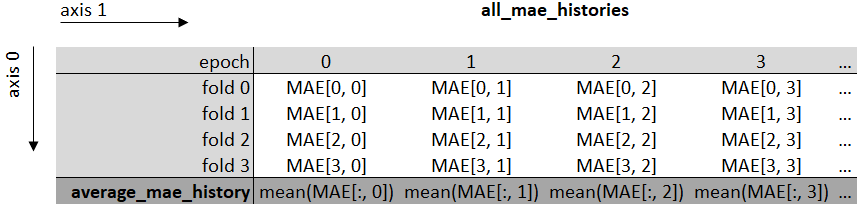

In [ ]:
# finale MAE berekend via evaluate()
print(all_scores)
print(np.mean(all_scores))

In [ ]:
# Neem MAE van laatste epoch uit all_mae_histories om hetzelfde resultaat te bekomen!
print([mae[-1] for mae in all_mae_histories])
print(np.mean([mae[-1] for mae in all_mae_histories]))

In [ ]:
# plotten
import matplotlib.pyplot as plt

# we laten de eerste 10 epochs weg (zie boek voor uitleg)
plt.plot(range(11, len(average_mae_history) + 1), average_mae_history[10:])
plt.xlabel("Epochs")
plt.ylabel("Validation MAE");

Conclusie: vanaf ongeveer 130 epochs begint de overfitting

=> model hertrainen op volledige training set gedurende 130 epochs

In [ ]:
model = build_model()
model.fit(train_data, train_labels, epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_labels)
test_mae_score

### 4.3.5. Generating predictions on new data

Regressie, dus we krijgen geen kansen maar echte prijzen!

In [ ]:
predictions = model.predict(test_data)
predictions[0]